In [73]:
import numpy as np
import cv2
from skimage import color
import matplotlib.pyplot as plt

In [74]:
def show(img, title):
    plt.title(title)
    plt.imshow(img)
    plt.savefig(title+'.jpg')
    plt.show()

In [75]:
def color_compensation(img):
    img = np.double(img)
    R = img[:, :, 2]
    G = img[:, :, 1]
    B = img[:, :, 0]
    Irm = np.mean(R, axis=0)
    Irm = np.mean(Irm)/256.0
    Igm = np.mean(G, axis=0)
    Igm = np.mean(Igm)/256.0
    Ibm = np.mean(B, axis=0)
    Ibm = np.mean(Ibm)/256.0
    a = 1
    Irc = R + a * (Igm-Irm)*(1-Irm)*G
    Irc = np.array(Irc.reshape(G.shape), np.uint8)
    Ibc = B + a * (Igm-Ibm)*(1-Ibm)*G
    Ibc = np.array(Ibc.reshape(G.shape), np.uint8)
    G = np.array(G, np.uint8)
    img = cv2.merge([Irc, G, Ibc])
    show(img, "color_compensation")
    return img

In [76]:
def gray_world(img):
    dim = np.shape(img)[2]
    img = np.array(img, dtype='uint8')
    out = np.zeros(np.shape(img))
    avg = np.mean(np.mean(img))
    for j in range(0, dim):
        m = np.sum(np.sum(img[:, :, j], axis=0), axis=0)
        n = np.size(img[:, :, j])
        scale = n/m
        g_weight = (avg*scale)
        out[:, :, j] = img[:, :, j]*g_weight
    out = np.array(out, dtype='uint8')
    show(out, "gray_world")
    return out

In [77]:
def gamma_correction(img, gamma=1.3):
    img = np.array(256*(img / 256) ** gamma, np.uint8)
    show(img, "gamma_correction")
    return img

In [78]:
def sharpen(img):
    filter1 = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    img = cv2.filter2D(img, -1, filter1)
    show(img, "sharpen")
    return img

In [79]:
def gauss(shape=(3, 3), sigma=0.5):
    m, n = [(ss-1.)/2. for ss in shape]
    y, x = np.ogrid[-m:m+1, -n:n+1]
    h = np.exp(-(x*x + y*y) / (2.*sigma*sigma))
    h[h < np.finfo(h.dtype).eps*h.max()] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

In [80]:
def saliency_weight(img):
    kernel = np.array(gauss((3, 3), 1))
    gfrgb = cv2.filter2D(img, -1, kernel, cv2.BORDER_WRAP)
    lab = color.rgb2lab(gfrgb)
    l = np.double(lab[:, :, 0])
    a = np.double(lab[:, :, 1])
    b = np.double(lab[:, :, 2])
    lm = np.mean(np.mean(l))
    am = np.mean(np.mean(a))
    bm = np.mean(np.mean(b))
    w = np.square(l-lm) + np.square(a-am) + np.square((b-bm))
    return w

In [81]:
def laplacian_weight(img):
    w = cv2.Laplacian(img, cv2.CV_64F)
    w = cv2.convertScaleAbs(w)
    return w

In [82]:
def saturation_weight(img, sigma=0.25, avg_=0.5):
    w = np.exp(-(img-avg_)**2/(2*np.square(sigma)))
    return w

In [83]:
def weight_maps(img):
    R = np.double(img[:, :, 0])/256
    WL = laplacian_weight(R)
    WS = saliency_weight(img)
    WSat = saturation_weight(R)
    return WL, WS, WSat

In [84]:
def iexpand(image):
    h = np.array([1, 4, 6, 4, 1])/16
    filt = (h.T).dot(h)
    outimage = np.zeros((image.shape[0]*2, image.shape[1]*2), dtype=np.float64)
    outimage[::2, ::2] = image[:, :]
    out = cv2.filter2D(outimage, cv2.CV_64F, filt)
    return out

In [85]:
def ireduce(image):
    h = np.array([1, 4, 6, 4, 1])/16
    filt = (h.T).dot(h)
    outimage = cv2.filter2D(image, cv2.CV_64F, filt)
    out = outimage[::2, ::2]
    return out

In [86]:
def gaussian_pyramid(image, depth=5):
    output = []
    output.append(image)
    tmp = image
    for i in range(0, depth):
        tmp = ireduce(tmp)
        output.append(tmp)
    return output

In [87]:
def lapl_pyramid(img_pyr):
    output = []
    k = len(img_pyr)
    for i in range(0, k-1):
        gu = img_pyr[i]
        egu = iexpand(img_pyr[i+1])
        if egu.shape[0] > gu.shape[0]:
            egu = np.delete(egu, (-1), axis=0)
        if egu.shape[1] > gu.shape[1]:
            egu = np.delete(egu, (-1), axis=1)
        output.append(gu - egu)
    output.append(img_pyr.pop())
    return output

In [88]:
def collapse(img_pyr):
    for i in range(len(img_pyr)-1, 0, -1):
        lap = iexpand(img_pyr[i])
        lap_last_dim = img_pyr[i-1]
        if lap.shape[0] > lap_last_dim.shape[0]:
            lap = np.delete(lap, (-1), axis=0)
        if lap.shape[1] > lap_last_dim.shape[1]:
            lap = np.delete(lap, (-1), axis=1)
        tmp = lap + lap_last_dim
    output = tmp
    return output

In [89]:
def split_rgb(img):
    (blue, green, red) = cv2.split(img)
    return red, green, blue

In [90]:
def pyramid_op(img):
    (R, G, B) = split_rgb(img)
    R = gaussian_pyramid(R)
    G = gaussian_pyramid(G)
    B = gaussian_pyramid(B)
    R = lapl_pyramid(R)
    G = lapl_pyramid(G)
    B = lapl_pyramid(B)
    return R, G, B

In [91]:
img = cv2.imread('initial_image.jpg')

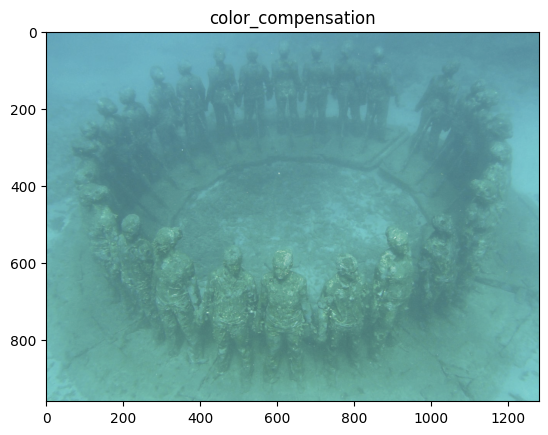

In [92]:
img = color_compensation(img)

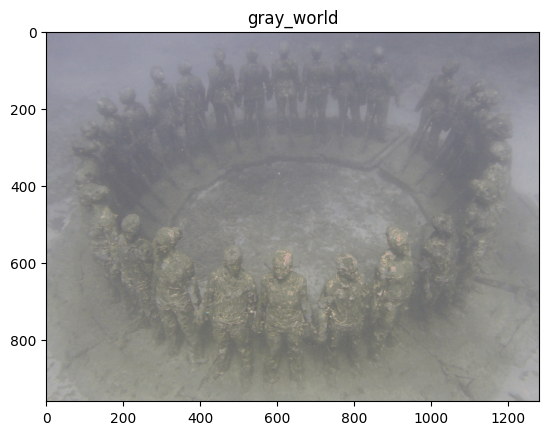

In [93]:
img = gray_world(img)

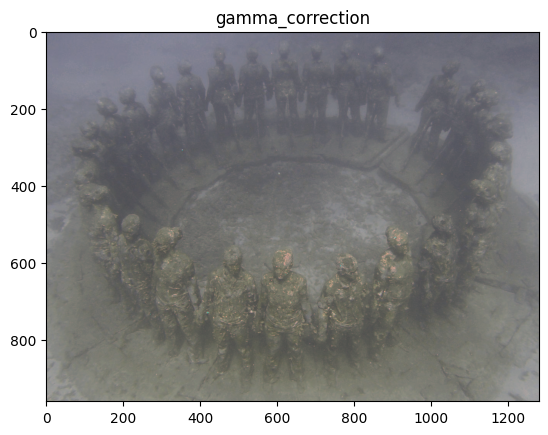

In [94]:
img1 = gamma_correction(img)

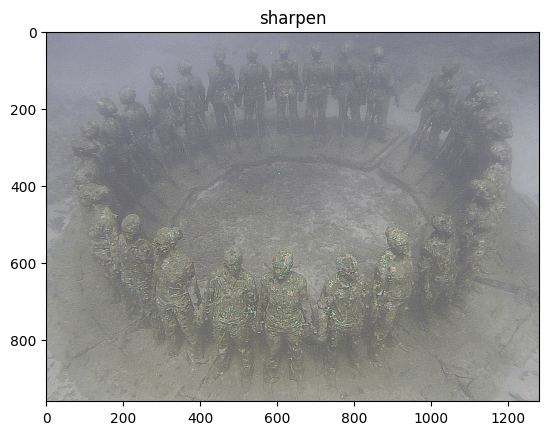

In [95]:
img2 = sharpen(img)

C:\Users\jagat\AppData\Local\Temp\ipykernel_2336\1754994107.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  R = np.array(W1, dtype=object) * r1 + np.array(W2, dtype=object) * r2
C:\Users\jagat\AppData\Local\Temp\ipykernel_2336\1754994107.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  G = np.array(W1, dtype=object) * g1 + np.array(W2, dtype=object) * g2
C:\Users\jagat\AppData\Local\Temp\ipykernel_2336\1754994107.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or

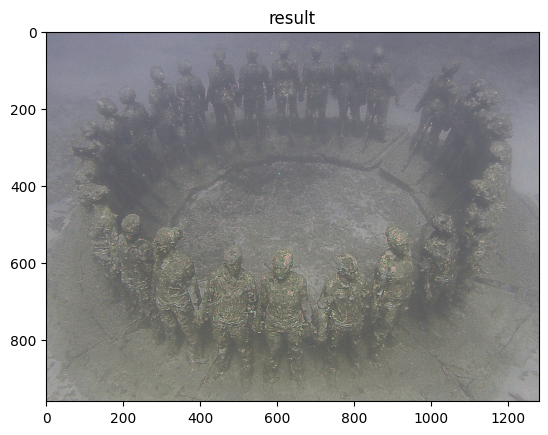

In [96]:
(WL1, WS1, WSat1) = weight_maps(img1)
(WL2, WS2, WSat2) = weight_maps(img2)


W1 = (WL1 + WS1 + WSat1)/(WL1 + WS1 + WSat1 + WL2 + WS2 + WSat2)
W2 = (WL2 + WS2 + WSat2)/(WL1 + WS1 + WSat1 + WL2 + WS2 + WSat2)


W1 = gaussian_pyramid(W1, 5)
W2 = gaussian_pyramid(W2, 5)

r1, g1, b1 = pyramid_op(img1)
r2, g2, b2 = pyramid_op(img2)

R = np.array(W1, dtype=object) * r1 + np.array(W2, dtype=object) * r2
G = np.array(W1, dtype=object) * g1 + np.array(W2, dtype=object) * g2
B = np.array(W1, dtype=object) * b1 + np.array(W2, dtype=object) * b2

R = collapse(R)
G = collapse(G)
B = collapse(B)


R[R < 0] = 0
R[R > 255] = 255
R = np.array(R, np.uint8)

G[G < 0] = 0
G[G > 255] = 255
G = np.array(G, np.uint8)

B[B < 0] = 0
B[B > 255] = 255
B = np.array(B, np.uint8)

result = cv2.merge([B, G, R])
show(result, "result")